# This notebook makes the Pseudobulks from processed single-cell data and formats relevant metadata

In [1]:
import gc
import sys
import pathlib
import subprocess
import pickle

import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

## Import buddi preprocessing module

In [2]:
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)
BUDDI_PATH = REPO_ROOT / "src"

sys.path.insert(0, str(BUDDI_PATH))

from buddi_v2 import preprocessing
from buddi_v2.preprocessing import utils
from buddi_v2.preprocessing import generate_pseudo_bulks
from buddi_v2.preprocessing.sc_augmentor import SCAugmentor, load_sc_augmentation_dir
from buddi_v2.plotting.plot_data import plot_data

2025-04-21 11:09:40.018373: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 11:09:40.027059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745255380.036081   64525 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745255380.038833   64525 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745255380.046719   64525 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
DATA_NAME = 'liver'

CELL_TYPE_COL = 'scpred_CellType'
CELL_TYPE_COL_SOURCE = 'names_merged'
SAMPLE_ID_COL = 'sample_id'
SAMPLE_ID_COL_SOURCE = 'mouse.id'
STIM_COL = 'stim'
STIM_COL_SOURCE = 'sex'
def get_stim_id(in_str):
    out_str = "female"
    if in_str == "male":
        out_str = "male"
           
    return(out_str)

GENE_ID_COL = 'gene_ids'
DATASPLIT_COL = 'isTraining'
DATASPLIT_SEED = 42

## Define Paths

In [4]:
## Input data path
DATA_PATH = pathlib.Path('.').absolute() / 'example_data'
assert DATA_PATH.exists()
SC_DATA_FILE = DATA_PATH / 'processed_sc_liver' / 'liver_droplet_processed.h5ad'
assert SC_DATA_FILE.exists()

## Cibersortx
CIBERSORTX_SIG_GENE_FILE = DATA_PATH / 'cibersort_liver' /\
    'CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt'
assert CIBERSORTX_SIG_GENE_FILE.exists()

## Output path
PREPROCESS_OUTPUT_PATH = pathlib.Path('.').absolute() / 'example_data' / 'preprocessed_data'
assert PREPROCESS_OUTPUT_PATH.exists(), 'Please create the output directory "preprocessed_data" first'
PREPROCESS_SC_AUGMENTED_OUTPUT_PATH = PREPROCESS_OUTPUT_PATH / 'sc_augmented'
PREPROCESS_SC_AUGMENTED_OUTPUT_PATH.mkdir(exist_ok=True)


## Load Processed Single Cell Data

In [5]:
adata = sc.read_h5ad(SC_DATA_FILE)
adata.var_names_make_unique()

if CELL_TYPE_COL_SOURCE not in adata.obs.columns:
    raise ValueError(f"Column {CELL_TYPE_COL_SOURCE} not found in the AnnData object.")
else:
    adata.obs[CELL_TYPE_COL] = adata.obs[CELL_TYPE_COL_SOURCE].tolist()
if SAMPLE_ID_COL_SOURCE not in adata.obs.columns:
    raise ValueError(f"Column {SAMPLE_ID_COL_SOURCE} not found in the AnnData object.")
else:
    adata.obs[SAMPLE_ID_COL] = adata.obs[SAMPLE_ID_COL_SOURCE].tolist()
if STIM_COL_SOURCE not in adata.obs.columns:
    raise ValueError(f"Column {STIM_COL_SOURCE} not found in the AnnData object.")
else:
    adata.obs[STIM_COL] = [get_stim_id(str(x)) for x in adata.obs[STIM_COL_SOURCE].tolist()]

adata.obs[DATASPLIT_COL] = "Train"
stim_idx = np.where(adata.obs[STIM_COL] == "female")[0]
adata.obs.loc[adata.obs.index[stim_idx], DATASPLIT_COL] = "Test"

adata.var[GENE_ID_COL] = adata.var.index.tolist()

### Sample vs Stim Contingency Table

In [6]:
ct = pd.crosstab(adata.obs[SAMPLE_ID_COL], adata.obs[STIM_COL])
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    print(ct)

stim       female  male
sample_id              
18-F-51       698     0
30-M-5          0   362


### Sample vs Cell Type Contingency Table

In [7]:
ct = pd.crosstab(adata.obs[CELL_TYPE_COL], adata.obs[SAMPLE_ID_COL])
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    print(ct)

sample_id                    18-F-51  30-M-5
scpred_CellType                             
NK                               109      88
b_cell                            24      73
hepatic_sinusoid                  27      80
hepatic_stellate                   2       5
hepatocyte                       267      29
kupffer                          221      44
myeloid_leukocyte                 40      34
plasmacytoid_dendritic_cell        8       9


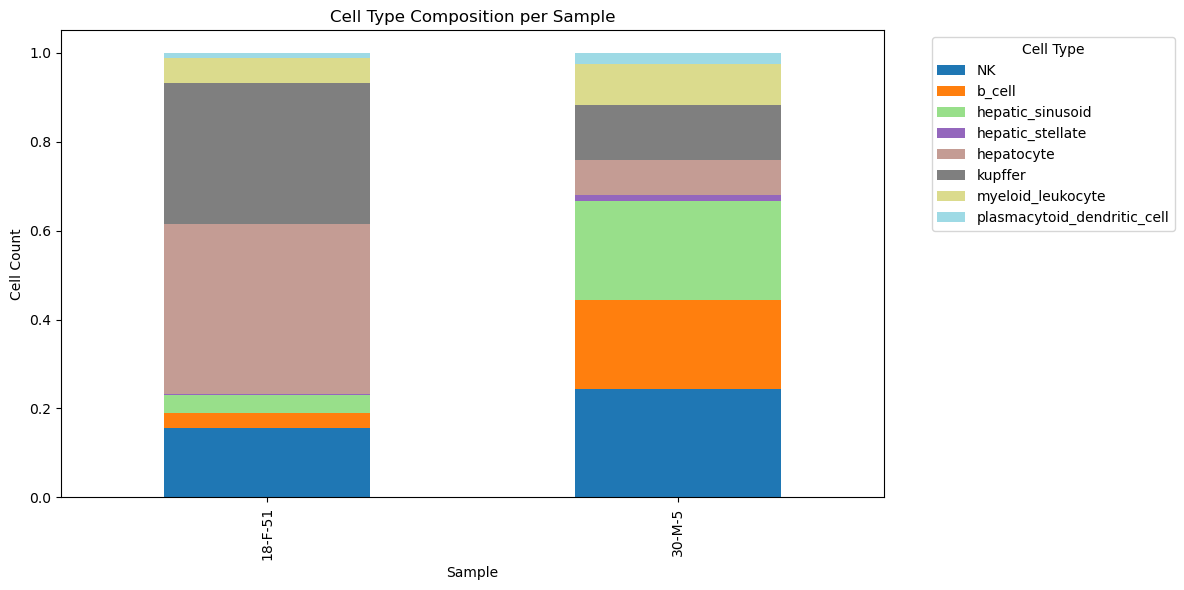

In [8]:
count_df = adata.obs.groupby([SAMPLE_ID_COL, CELL_TYPE_COL]).size().reset_index(name='count')
pivot_df = count_df.pivot(index=SAMPLE_ID_COL, columns=CELL_TYPE_COL, values='count').fillna(0)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20', ax=ax)

plt.xlabel('Sample')
plt.ylabel('Cell Count')
plt.title('Cell Type Composition per Sample')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Augment sc Data

### With new SCAugmentor class

In [9]:
augmentor = SCAugmentor(
    adata=adata,
    sample_col=SAMPLE_ID_COL,
    split_col=DATASPLIT_COL,
    celltype_col=CELL_TYPE_COL,
    gene_id_col=GENE_ID_COL,
)

-----------------------------------------------
PseudoBulkAugmentor initialised with:
  #Samples : 2
  #Stims   : 2
  #Splits  : 2
  #Cell types : 8

Contingency table (sample × split):
isTraining  Test  Train
sample_id              
18-F-51      698      0
30-M-5         0    362
-----------------------------------------------



In [10]:
# Configuring the PseudoBulk generation flavor

augmentor.configure_random_pseudobulks(
    n_bulks=1_000, # 1, 000 generated per sample
    n_cells=5_000, # 5, 000 cells per pseudobulk
    mean=5.0, # Mean for log-normal distribution sampling
    variance_range=(1.0, 3.0), # Variance range for log-normal distribution sampling
)
augmentor.configure_realistic_pseudobulks(
    n_bulks=0, # No realistic pseudobulks generated
)
augmentor.configure_singlecell_pseudobulks(
    n_bulks=100, # 100 pseudobulks generated per sample per cell type 
    n_cells=5_000,
    background_prop=0.01,
)

augmentor.configure_pseudobulk_noise(
    cell_noise=(0, 0.1), # randomly generated noise with log-normal mean 0 and std 0.1
    use_sample_noise=False, # Do not use sample noise
)

In [11]:
print("Random  :", augmentor._random_cfg)
print("Realistic:", augmentor._realistic_cfg)
print("Single  :", augmentor._single_cfg)
print("Noise   :", augmentor._noise_cfg)

Random  : {'n_bulks': 1000, 'n_cells': 5000, 'mean': 5.0, 'variance_range': (1.0, 3.0)}
Realistic: {'n_bulks': 0, 'n_cells': 5000, 'min_corr': 0.8}
Single  : {'n_bulks': 100, 'n_cells': 5000, 'background_prop': 0.01}
Noise   : {'cell_noise': [array([1.07269077, 0.96070759, 1.04186931, ..., 1.00983584, 0.85778789,
       0.86006931]), array([1.18028049, 0.9710207 , 0.89215229, ..., 1.03035052, 1.0205425 ,
       0.88028123]), array([1.06777393, 1.12323596, 1.15613483, ..., 0.94641668, 0.97673728,
       0.96485296]), array([1.13381728, 1.25420258, 0.89037961, ..., 1.03631818, 0.99093618,
       0.99853677]), array([0.95195278, 0.87071171, 1.02483783, ..., 1.00851885, 1.07985996,
       0.81797732]), array([0.98059862, 0.95979158, 0.97259992, ..., 0.8894069 , 1.14442666,
       1.07134818]), array([0.86715478, 1.10651499, 1.01741231, ..., 0.99265736, 0.878808  ,
       0.97266602]), array([1.18484192, 0.96856603, 0.85368443, ..., 0.86900393, 1.06845563,
       0.98150229])], 'use_sample_

In [12]:
augmentor.run(
    save_path=PREPROCESS_OUTPUT_PATH,
    augmentation_name=f'sc_augmented_new',
    seed=42,
    overwrite=True,
)

Generating pseudo‑bulk profiles for sample 18-F-51, stim female, split Test …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:20<00:00, 48.30it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 800/800 [00:17<00:00, 44.75it/s]


  Done for 18-F-51, female, Test.

Generating pseudo‑bulk profiles for sample 18-F-51, stim female, split Train …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 18-F-51, stim male, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 18-F-51, stim male, split Train …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 30-M-5, stim female, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 30-M-5, stim female, split Train …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 30-M-5, stim male, split Test …
>No matching cells – skipping.
Generating pseudo‑bulk profiles for sample 30-M-5, stim male, split Train …
  >Generating random‑prop pseudo‑bulks…


100%|██████████| 1000/1000 [00:22<00:00, 45.24it/s]


  >Generating single‑cell‑dominant pseudo‑bulks…


100%|██████████| 800/800 [00:18<00:00, 42.81it/s]


  Done for 30-M-5, male, Train.



Sanity Check visualization for augmented data

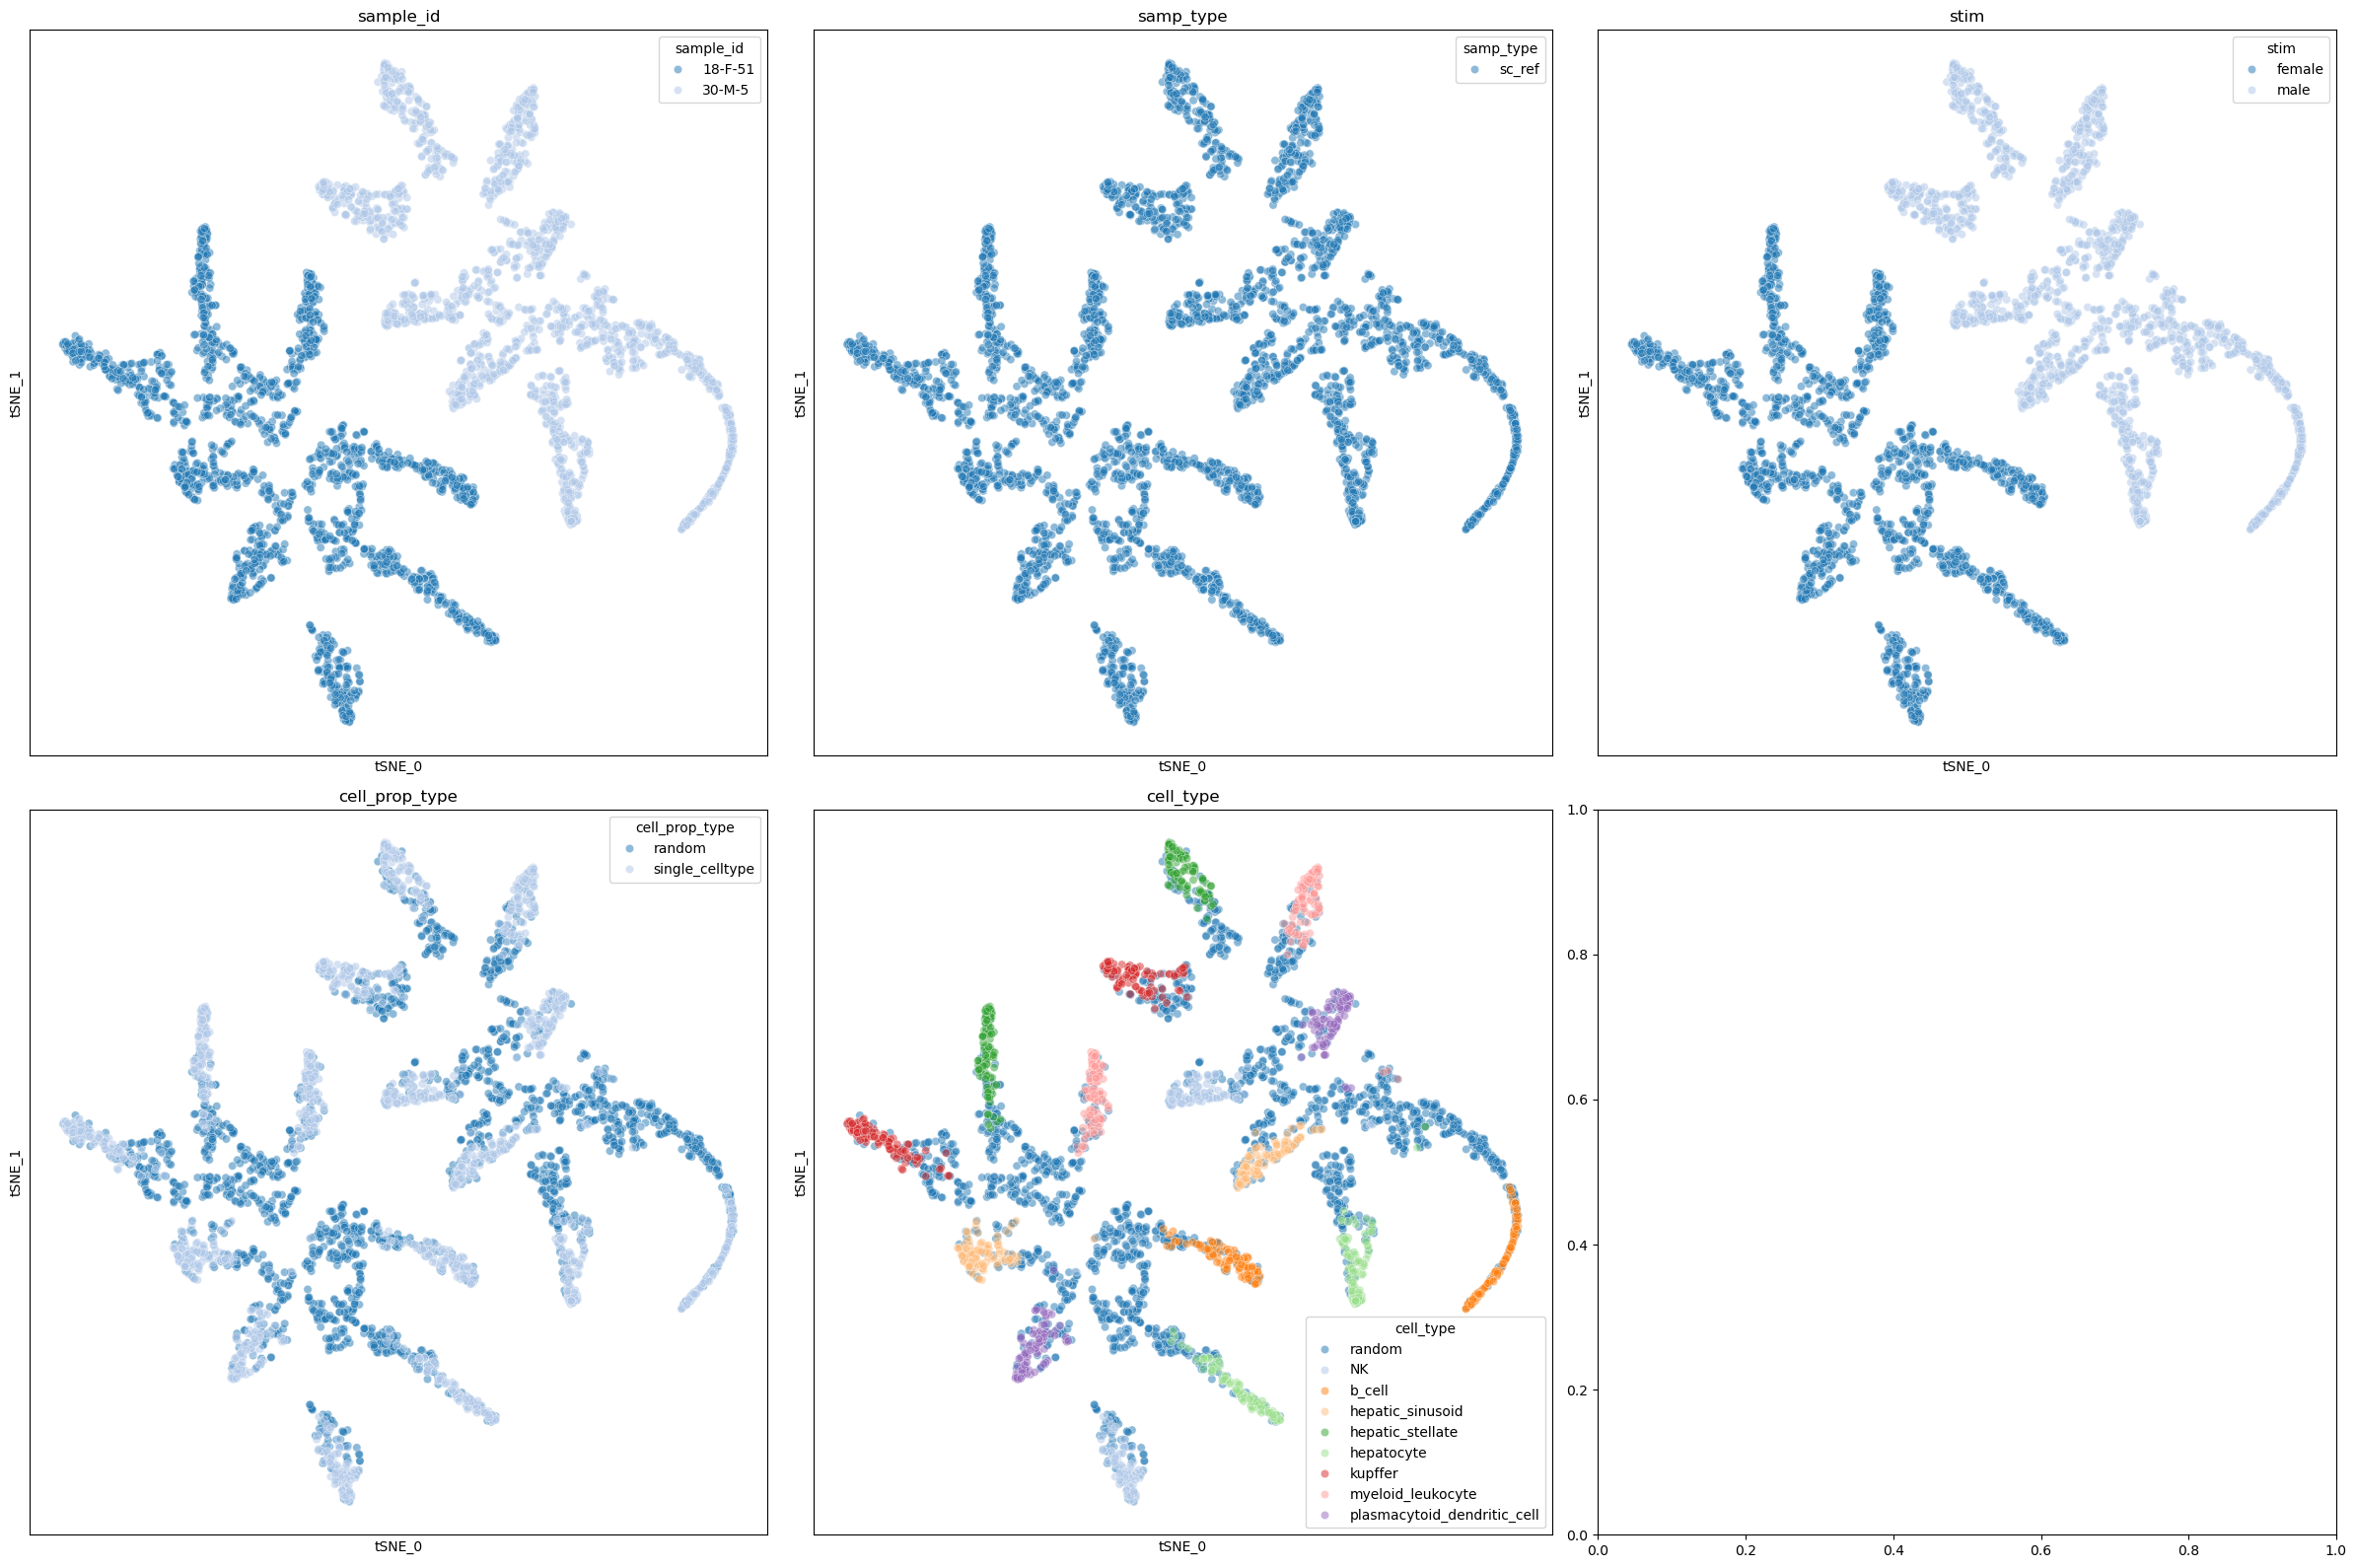

603

In [13]:
pseudo_df, prop_df, meta_df = load_sc_augmentation_dir(
    PREPROCESS_OUTPUT_PATH / 'sc_augmented_new'
)

n_top=2000
def _mad(col):
    return median_abs_deviation(col, nan_policy="omit", scale=1.0)
x = pseudo_df.loc[:,pseudo_df.apply(_mad, axis=0).nlargest(n_top).index]

plot_data(
    x.values,
    meta_df,
    panel_width=8,
    show_plot=True
)

del pseudo_df
del prop_df
del meta_df
del x

gc.collect()

### With old pipeline

Output Gene ids

In [14]:
gene_out_file = PREPROCESS_SC_AUGMENTED_OUTPUT_PATH / f'{DATA_NAME}_genes.pkl'
gene_ids = adata.var[GENE_ID_COL]
pickle.dump(gene_ids, open( gene_out_file, "wb" ))

Make Pseudo-bulks

In [15]:
ADD_PER_CELL_TYPE_NOISE = False
N_CELLS_PER_PSEUDO_BULK = 5_000
N_PSEUDO_BULKS_PER_CONDITION = 1_000

gene_ids = adata.var[GENE_ID_COL]
samples = adata.obs[SAMPLE_ID_COL].unique()
stims = adata.obs[STIM_COL].unique()

cell_types = adata.obs[CELL_TYPE_COL].unique() # Global cell types
cell_order = sorted(cell_types) # order proportion columns

datasplits = adata.obs[DATASPLIT_COL].unique()

n_samples = len(samples)
n_genes = len(gene_ids)
n_cell_types = len(cell_order)

# Define cell-type level noise for the generated pseudo-bulk profiles
if ADD_PER_CELL_TYPE_NOISE:
    # this produces a list of numpy arrays, each of length n_genes
    # to reflect the expression noise associated with each specific cell type
    per_cell_type_noise = [
        np.random.lognormal(0, 1, n_genes) for i in range(n_cell_types)]
else:
    per_cell_type_noise = None

In [16]:
# Generate pseudo-bulk profiles grouping by sample_id and stim
for _sample in samples:
    for _stim in stims:
        for _datasplit in datasplits:

            print(f"Generating pseudo-bulk profiles for sample {_sample}, stim {_stim}, and datasplit {_datasplit} ...")
            
            ## Subset adata to the current sample, stim and train/test split
            subset_idx = np.where(
                np.logical_and.reduce((
                    adata.obs[SAMPLE_ID_COL] == _sample, 
                    adata.obs[STIM_COL] == _stim,
                    adata.obs[DATASPLIT_COL] == _datasplit,
                ))
            )[0]
            
            if len(subset_idx) == 0:
                continue
            subset_adata = adata[subset_idx, :]

            ## Cell type that is present in the subset, will inform the 
            ## down stream workflow of potential missing cell types to skip
            present_cell_types = subset_adata.obs[CELL_TYPE_COL].unique().tolist()

            ## Subset the cell_df to the present cell types
            cell_df = preprocessing.utils.subset_adata_by_cell_type(
                subset_adata, 
                cell_type_col=CELL_TYPE_COL,
                cell_order=cell_order
            )

            print(">Generating random prop pseudo-bulk profiles ...")

            random_count_df = preprocessing.utils.generate_log_normal_counts(
                cell_order=cell_order, 
                num_cells=N_CELLS_PER_PSEUDO_BULK, 
                num_samples=N_PSEUDO_BULKS_PER_CONDITION,
                present_cell_types=present_cell_types
            )
            random_props_df = preprocessing.utils.generate_prop_from_counts(
                random_count_df,
            )
            random_pseudobulk_df = preprocessing.generate_pseudo_bulks.generate_pseudo_bulk_from_counts(
                in_adata=subset_adata,
                cell_df=cell_df,
                count_df=random_count_df,
                cell_noise=per_cell_type_noise,
                use_sample_noise=False
            )
            random_pseudobulk_metadata_df = pd.DataFrame(
                data = {
                    SAMPLE_ID_COL: [_sample]*N_PSEUDO_BULKS_PER_CONDITION,
                    STIM_COL: [_stim]*N_PSEUDO_BULKS_PER_CONDITION,
                    'cell_prop_type': ['random']*N_PSEUDO_BULKS_PER_CONDITION,
                    'cell_type': ['random']*N_PSEUDO_BULKS_PER_CONDITION,
                    'samp_type': ['sc_ref']*N_PSEUDO_BULKS_PER_CONDITION,
                }
            )

            print(">Generating single cell dominant pseudo-bulk profiles ...")

            single_cell_props_df, single_cell_metadata = preprocessing.utils.generate_single_celltype_dominant_props(
                num_samp=100,
                cell_order=cell_order,
                present_cell_types=present_cell_types,
                return_metadata=True
            )
            single_cell_counts_df = preprocessing.utils.generate_counts_from_props(
                single_cell_props_df,
                num_cells=N_CELLS_PER_PSEUDO_BULK
            )
            single_cell_pseudobulk_df = preprocessing.generate_pseudo_bulks.generate_pseudo_bulk_from_counts(
                in_adata=subset_adata,
                cell_df=cell_df,
                count_df=single_cell_counts_df,
                cell_noise=per_cell_type_noise,
                use_sample_noise=False
            )
            n_single_celltype_pbs = len(single_cell_pseudobulk_df)
            single_cell_metadata_df = pd.DataFrame(
                data = {
                    SAMPLE_ID_COL: [_sample]*n_single_celltype_pbs,
                    STIM_COL: [_stim]*n_single_celltype_pbs,
                    'cell_prop_type': ['single_celltype']*n_single_celltype_pbs,
                    'cell_type': single_cell_metadata,
                    'samp_type': ['sc_ref']*n_single_celltype_pbs,
                }
            )

            print('>Concatenating the two types of pseudo-bulk profiles ...')
            props_df = pd.concat([random_props_df, single_cell_props_df])
            pseudobulk_df = pd.concat([random_pseudobulk_df, single_cell_pseudobulk_df])

            metadata_df = pd.concat(
                [random_pseudobulk_metadata_df, single_cell_metadata_df]
            )
            
            print(">Writing the pseudo-bulk profiles ...")
            pseudobulk_file = PREPROCESS_SC_AUGMENTED_OUTPUT_PATH / f'{DATA_NAME}_{_sample}_{_stim}_{_datasplit}_pseudo_splits.pkl'
            prop_file = PREPROCESS_SC_AUGMENTED_OUTPUT_PATH / f'{DATA_NAME}_{_sample}_{_stim}_{_datasplit}_prop_splits.pkl'
            meta_file = PREPROCESS_SC_AUGMENTED_OUTPUT_PATH / f'{DATA_NAME}_{_sample}_{_stim}_{_datasplit}_meta_splits.pkl'

            pickle.dump( props_df, open( prop_file, "wb" ) )
            pickle.dump( pseudobulk_df, open( pseudobulk_file, "wb" ) )
            pickle.dump( metadata_df, open( meta_file, "wb" ) )

            print(f"Done for sample {_sample}, stim {_stim}, and datasplit {_datasplit}\n")

Generating pseudo-bulk profiles for sample 18-F-51, stim female, and datasplit Test ...
>Generating random prop pseudo-bulk profiles ...


100%|██████████| 1000/1000 [00:21<00:00, 46.86it/s]


>Generating single cell dominant pseudo-bulk profiles ...


100%|██████████| 800/800 [00:17<00:00, 44.98it/s]


>Concatenating the two types of pseudo-bulk profiles ...
>Writing the pseudo-bulk profiles ...
Done for sample 18-F-51, stim female, and datasplit Test

Generating pseudo-bulk profiles for sample 18-F-51, stim female, and datasplit Train ...
Generating pseudo-bulk profiles for sample 18-F-51, stim male, and datasplit Test ...
Generating pseudo-bulk profiles for sample 18-F-51, stim male, and datasplit Train ...
Generating pseudo-bulk profiles for sample 30-M-5, stim female, and datasplit Test ...
Generating pseudo-bulk profiles for sample 30-M-5, stim female, and datasplit Train ...
Generating pseudo-bulk profiles for sample 30-M-5, stim male, and datasplit Test ...
Generating pseudo-bulk profiles for sample 30-M-5, stim male, and datasplit Train ...
>Generating random prop pseudo-bulk profiles ...


100%|██████████| 1000/1000 [00:22<00:00, 45.37it/s]


>Generating single cell dominant pseudo-bulk profiles ...


100%|██████████| 800/800 [00:18<00:00, 42.39it/s]


>Concatenating the two types of pseudo-bulk profiles ...
>Writing the pseudo-bulk profiles ...
Done for sample 30-M-5, stim male, and datasplit Train



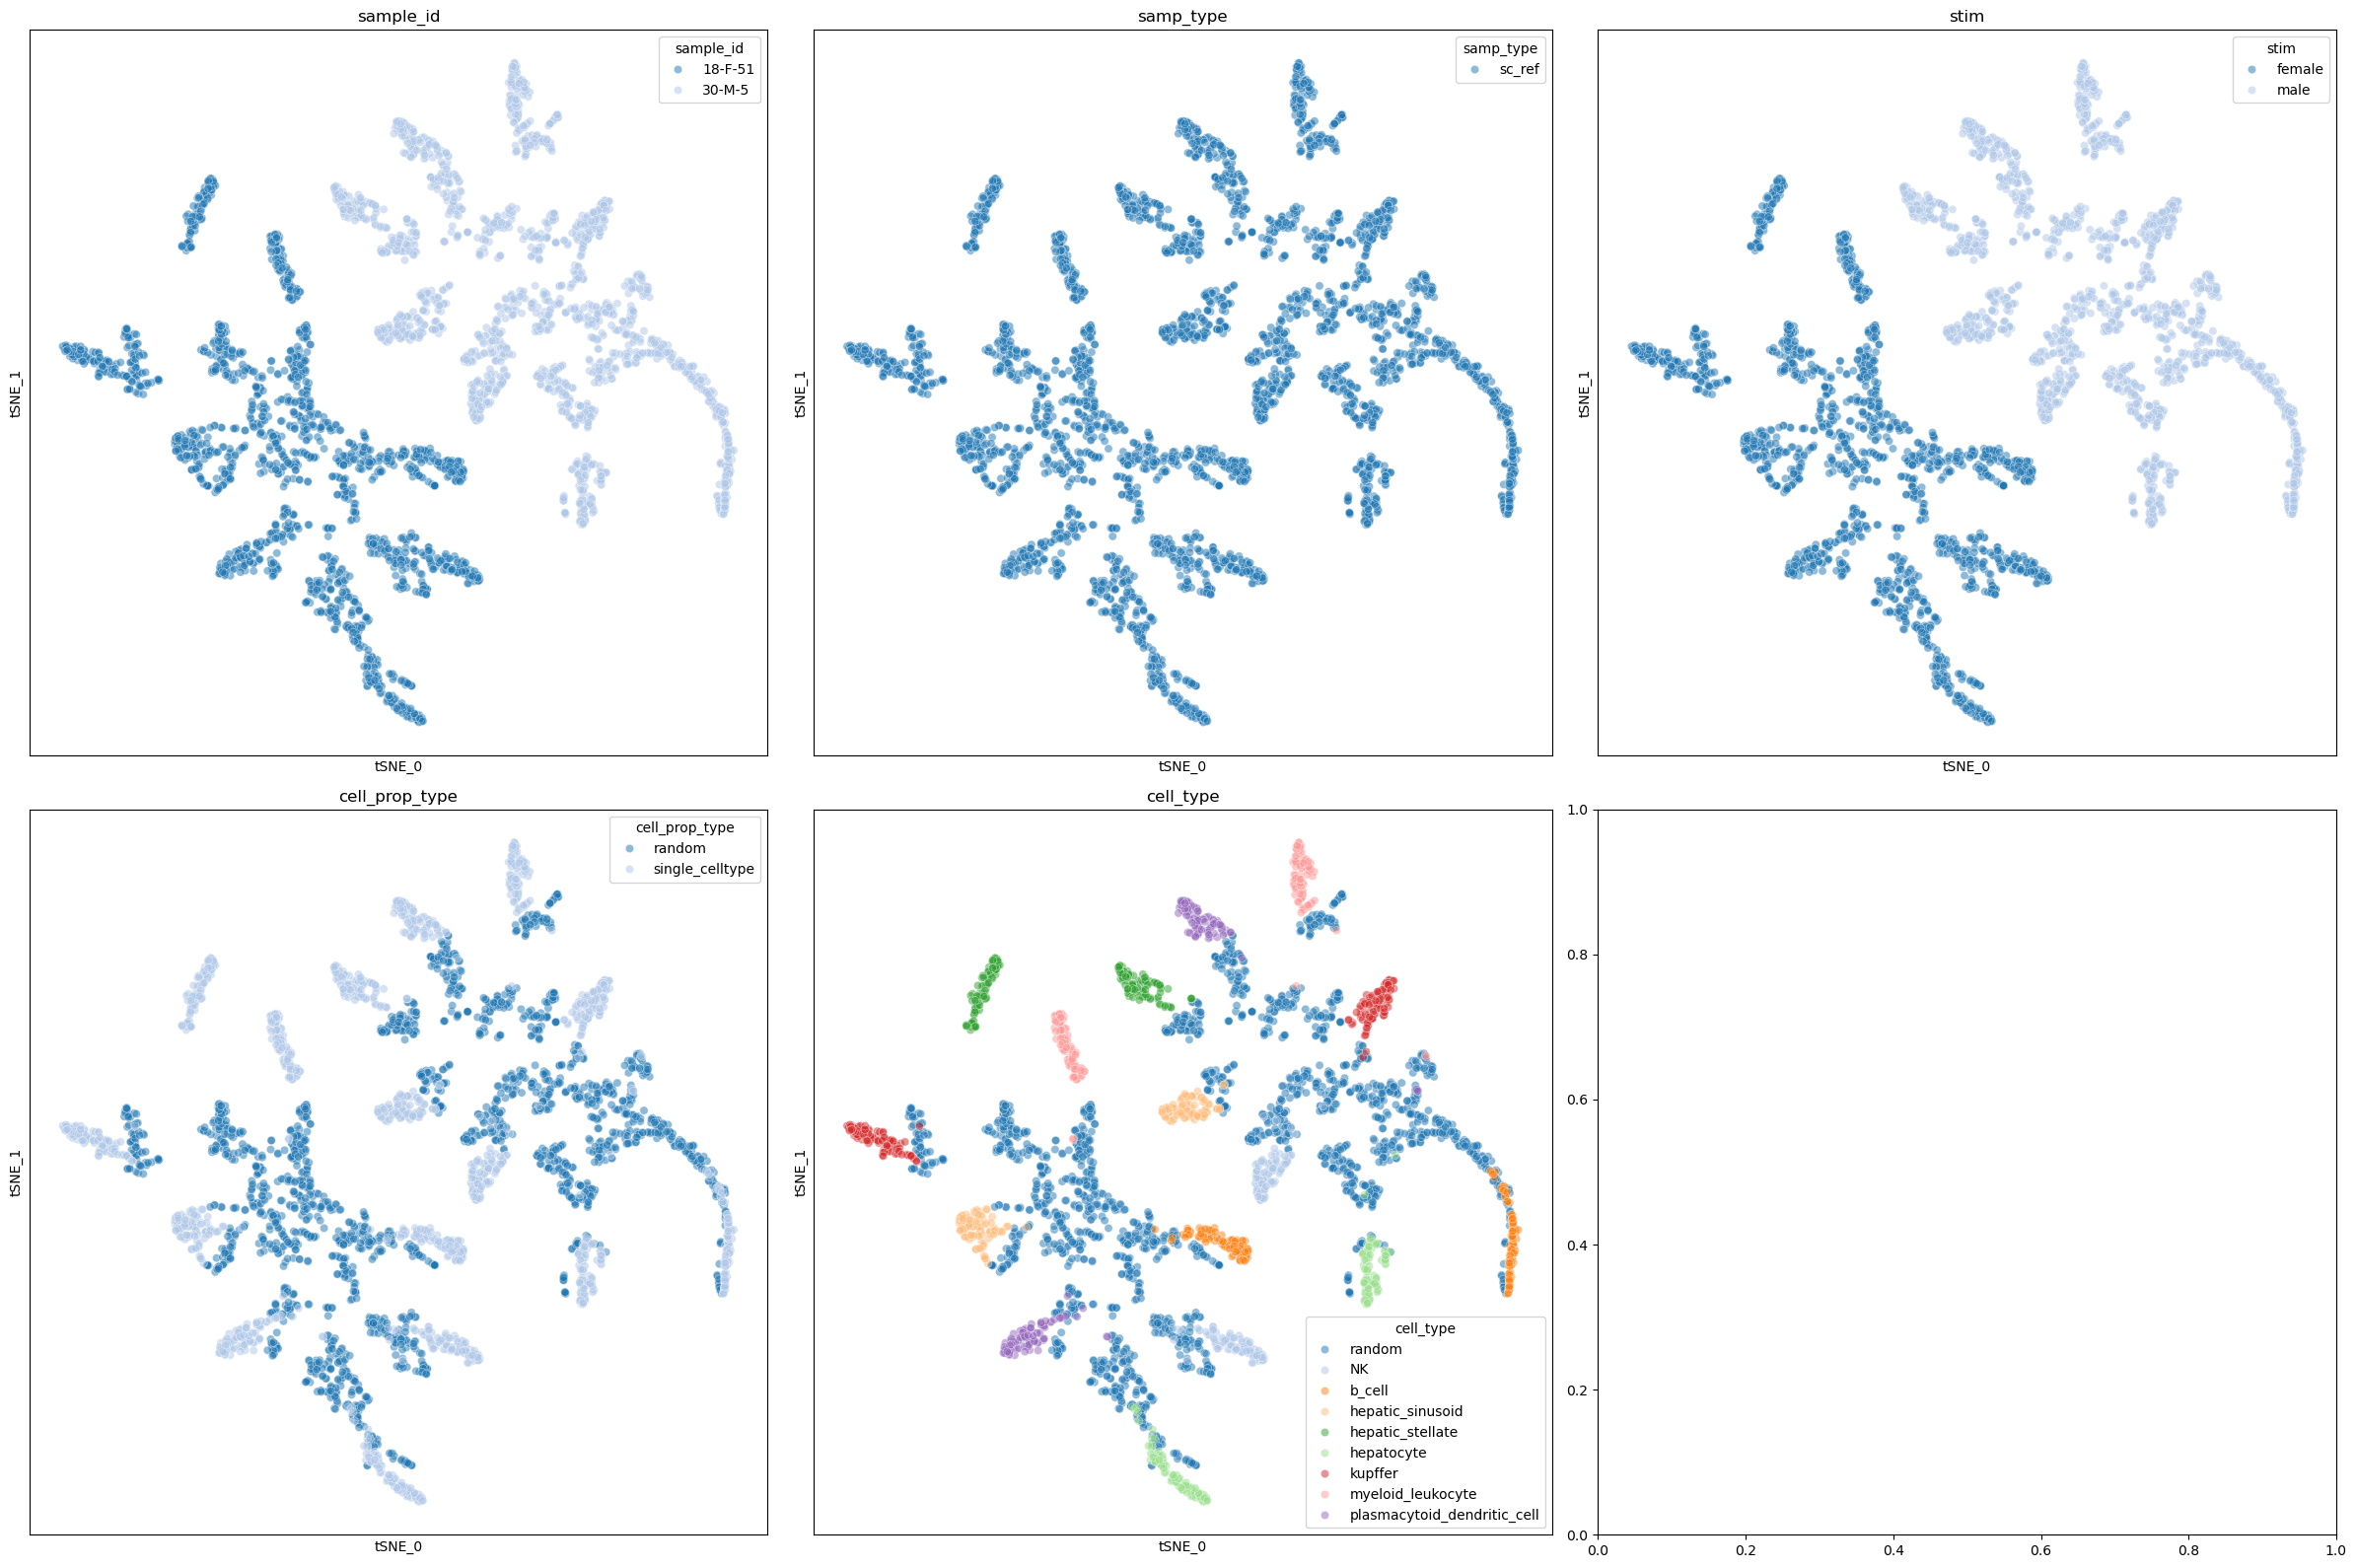

2512

In [17]:
pseudo_df, prop_df, meta_df = load_sc_augmentation_dir(
    PREPROCESS_OUTPUT_PATH / 'sc_augmented'
)

n_top=2000
def _mad(col):
    return median_abs_deviation(col, nan_policy="omit", scale=1.0)
x = pseudo_df.loc[:,pseudo_df.apply(_mad, axis=0).nlargest(n_top).index]

plot_data(
    x.values,
    meta_df,
    panel_width=8,
    show_plot=True
)

del pseudo_df
del prop_df
del meta_df
del x

gc.collect()